In [49]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings

from itertools import product

# Variable Elimination for the moralized graph

Implement inference algorithms for computing the conditional distribution of $X_{10}$ and $X_{11}$ given the observed variables for any choice of parameters $\psi^{(1)}, \ldots, \psi^{(11)}$.

### Synthetic data

In [50]:
alpha = 0.5

Elemination order

In [51]:
# The scope consist of the parents and the node itself
variables_to_eliminate = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']
elimination_scope = [("X1", ['X7', 'X8']),("X2", ['X4', 'X8']),("X3", ['X9', 'X8']),
                     ("X5", ['X9', 'X8']),("X4", ['X11', 'X8', 'X9']),("X6", ['X7', 'X10']),
                     ("X7", []),("X8", []),("X9", ['X10', 'X6']), ("X10", ['X7']),("X11", ['X8', 'X9'])]


### From CPD to factor representation

In [52]:
def create_factor(variable: str, parent_list: list):
    """
    Creates a dataframe with all possible combinations of outcomes for parent- and child nodes

    Arguments:
    variable (string): The name of the child node, 'Xi'
    parent_list (list): A list of strings, representing the parent nodes ['Xj', 'Xk']

    Returns:
    pandas.DataFrame: A dataframe with all possible outcomes
    """
    d = 1 + len(parent_list)
    columns = parent_list + [variable]
    df = pd.DataFrame(product([0,1],repeat=d),columns=columns)
    return df

def cpd_factor(variable: str, parent_list: list, alpha: float):
    """ 
    Creates a factor using the create_factor() function, and adds a factor value to each outcome 

    Arguments:
    variable (string): The name of the child node
    parent_list (list): The names of the parent nodes
    alpha (float): The alpha parameter

    Returns:
    pandas.DataFrame: A factor, in the form of a pandas dataframe

    """
    cpd = create_factor(variable, parent_list)
    variables = list(cpd.columns)
    n = len(variables)
    cpd_ = cpd.copy() 
    if n == 1:
        cpd_["prob"] = 1 - alpha
        return cpd_
    else:
        child = variables[n-1]
        # generate factor 
        parents = cpd_.iloc[:,:-1].copy()
        parents["sum"] = parents.sum(axis=1)
        cpd_["prob"] = 1 - (alpha ** (1 + parents["sum"]))
        # dataframe.where() updates the probability where condition is false
        # St. we can compute the probability of P(X=0|parents) = 1 - P(X=1|parents)
        cpd_["prob"].where(cpd_[f"{child}"] == 1, 1-cpd_["prob"],axis=0,inplace=True)
        return cpd_



In [53]:
# Example use    
# factor_test = cpd_factor(elimination_scope[2][0], elimination_scope[2][1], alpha)
# factor_test

In [54]:
# Generate factors for all nodes
# list form: [(factor, variable name), ... ]
factor_list = []
for elm in elimination_scope:
    name = 'phi_' + str(elm[0])
    cpd = cpd_factor(elm[0], elm[1], alpha)
    factor_list.append((cpd, name))

In [55]:
# Factor for X1
# print(factor_list[0])

# Sum product

In [56]:
def factor_product(factor_1: pd.DataFrame, factor_2: pd.DataFrame):
    """
    Multiplies two factors 

    Arguments:
    factor1 (pandas.DataFrame): a factor in the form of a dataframe
    factor2 (pandas.DataFrame): a factor in the form of a dataframe

    Returns:
    new_factor (pandas.DataFrame): A new factor, joined at the common nodes, with the factor values multiplied

    """
    # List of all common nodes to join on
    nodes_to_join = factor_1.columns.intersection(factor_2.columns)
    nodes_to_join = nodes_to_join.drop("prob")
    nodes = list(nodes_to_join)

    # Inner join the factors by common nodes
    new_factor = factor_1.merge(factor_2, how='inner', on=nodes)
    new_factor["prob"] = new_factor["prob_x"]*new_factor["prob_y"] # Multiply the probabilities
    new_factor = new_factor.drop(columns=["prob_x","prob_y"])
    return new_factor
    

In [57]:
# Example use - multiplication of factors
# factor_product(factor_list[0][0], factor_list[1][0])

In [58]:
# From algorithm 9.1 in the book (p. 298)
def sum_product_eliminate_var(factors : list, var : str, print_info = False):
    """
    Eliminates one variable and multiplies all factors with that variable in their scope

    Arguments:
    factors (list): The set of all factors currently in the network
    var (str): The name of the variable to be eliminated
    print_info (bool): Command to print debugging information or not

    Returns: 
    list: A list containing the factors without the eliminated variable in the scope plus the product of the factors with the eliminated variable in the scope 
    """
    factors_list = [i[0] for i in factors] # Factors
    names_list = [i[1] for i in factors] # Names of factors

    lst_scope = []   # Factors in scope
    lst_scope_i = [] # Names of factors in scope   
    lst_not_scope = [] # Factors not in scope
    lst_not_scope_i = [] # Names of factors not in scope

    # Split factors into variable in scope and variable not in scope
    for i in range(0, len(factors_list)):
        if var in factors_list[i].columns:
            lst_scope.append(factors_list[i])
            lst_scope_i.append(names_list[i])
        else:
            lst_not_scope.append(factors_list[i])
            lst_not_scope_i.append(names_list[i])

    # Multiply all factors with variable in scope
    factor_ = lst_scope[0]
    for i in range(1, len(lst_scope)):
        factor_ = factor_product(factor_, lst_scope[i])

    # All variables that should not be marginalized
    col = list(factor_.columns[factor_.columns != var].drop("prob")) 

    # Marginalize the variable / sum out variable
    tau = factor_.groupby(col, as_index = False)['prob'].sum()
    tau_name = 'tau_' + str(var) 

    # Add the new factor to the list of factors not in scope
    lst_not_scope = lst_not_scope + [tau]
    lst_not_scope_i = lst_not_scope_i + [tau_name]
    
    # Debugging prints
    if print_info:
        for elm in lst_scope:
            print(elm.columns)
        print(lst_scope_i)

    return list(zip(lst_not_scope, lst_not_scope_i))



In [59]:
# Example use of sum_product_eliminate_var()
print(sum_product_eliminate_var(factor_list, 'X1', False))

[(   X4  X8  X2   prob
0   0   0   0  0.500
1   0   0   1  0.500
2   0   1   0  0.250
3   0   1   1  0.750
4   1   0   0  0.250
5   1   0   1  0.750
6   1   1   0  0.125
7   1   1   1  0.875, 'phi_X2'), (   X9  X8  X3   prob
0   0   0   0  0.500
1   0   0   1  0.500
2   0   1   0  0.250
3   0   1   1  0.750
4   1   0   0  0.250
5   1   0   1  0.750
6   1   1   0  0.125
7   1   1   1  0.875, 'phi_X3'), (   X9  X8  X5   prob
0   0   0   0  0.500
1   0   0   1  0.500
2   0   1   0  0.250
3   0   1   1  0.750
4   1   0   0  0.250
5   1   0   1  0.750
6   1   1   0  0.125
7   1   1   1  0.875, 'phi_X5'), (    X11  X8  X9  X4    prob
0     0   0   0   0  0.5000
1     0   0   0   1  0.5000
2     0   0   1   0  0.2500
3     0   0   1   1  0.7500
4     0   1   0   0  0.2500
5     0   1   0   1  0.7500
6     0   1   1   0  0.1250
7     0   1   1   1  0.8750
8     1   0   0   0  0.2500
9     1   0   0   1  0.7500
10    1   0   1   0  0.1250
11    1   0   1   1  0.8750
12    1   1   0   0  0.1250


In [60]:
def sum_product_ve(factors: list, order: list):
    """ 
    Run the sum_product_eliminate_var() function on all variables to be eliminated

    Arguments:
    factors (list): list of factors
    order (list): list of variables in elimination order

    Returns:
    factors (list): list of remaining factors after eliminating all variables in the elimination order
    """

    # For each variable in the elimination order
    for var in order:
        factors = sum_product_eliminate_var(factors, var)
    return factors

In [61]:
# Example use of sum_product_ve()
print(sum_product_ve(factor_list, variables_to_eliminate))

[(   X11  X10      prob
0    0    0  0.095215
1    0    1  0.134399
2    1    0  0.279785
3    1    1  0.490601, 'tau_X9')]


In [62]:
def cond_prob_ve (factors: list, queries: list, evidence: list, order: list):
    """ 
    Calculates the conditional probability of the query variables, given evidence. Corresponds to Algorithm 9.2 in PGM.

    Arguments: 
    factors (list): list of factors
    queries (list): list of variables (string) to be inferred
    evidence (list): list of tuples containing the name and a value of a variable, e.g. ('X1',1) corresponding to X1=1.as_integer_ratio
    order (list): list of variables in elimination order

    Returns:
    alpha (pd.DataFrame): CPD table containing the conditional distribution of the query variables given the evidence
    phi (list of tuples): list containing tuples of factors and the name of the factor e.g. (pd.DataFrame, 'phi_Xi')
    """
    order_ = order.copy() # Fix for wierd python handeling of list
    factors_list = [i[0] for i in factors] # Factors
    names_list = [i[1] for i in factors] # Names of factors

    for i in range(0,len(factors_list)): # Loop through factors
        for elm in evidence: # Loop through evidence
            if elm[0] in factors_list[i].columns:
                # Retrict factor to evidence == e, and replace in factor list
                factors_list[i] = factors_list[i][factors_list[i][elm[0]]==elm[1]]
                # print('factor list: ', factor_list[i])

    concat_factor_list = list(zip(factors_list,names_list))
    
    phi = sum_product_ve(concat_factor_list, order_)

    alpha = phi[0][0].groupby(queries, as_index = False)['prob'].sum()
    alpha['prob'] = alpha['prob'] / alpha['prob'].sum() # Normalize the probability
   
    return alpha, phi

Example use of cond_prob_ve()

In [63]:
# evidence - observed values e for variables in E
evidence = [('X1', 1), ('X2',1), ('X3',1),('X4',1),("X5",1),('X6',1),('X7',0),('X8',1),('X9',1)] # Change the values to your preference.

# If a variable is in query it cannot be in variables_to_eliminate
# order - Elimination order (order)
variables_to_eliminate = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']

# query_var - Set of query variables Y to be inferred
query_var = ['X10']

cond_prob_ve(factor_list, query_var, evidence, variables_to_eliminate)[0]

,X10,prob
0,0,0.363636
1,1,0.636364


# Apply sum-product

The following code "proofs" that our algorithm works.
 - It do take a long time to run, but the we should be able to optimize if we don't run cond_prob_ve inside the for-loop in the function dataframe_inference

Apply evidence to the inference algorithm:
 - Loop through each row in the dataframe and apply the columns to sum_product as evidence.

## Inference
Test the inference algorithm using simulated data

In [64]:
def convert_to_evidence_format(data : list, pick : list) -> list:
    """ 
    This is a helper function to create a factor from a dataset. 
    Method: convert the data into the same format as the evidence list by looping through the data 
    and creating a list of tuples.

    Arguments: 
    data (list): list of lists with data
    pick (list): List of variables X1, ..., X9

    Returns:
    evidence (list): example: [(X1, 1), (X2, 0), (X3, 1), (X4, 0), (X5, 1), (X6, 0), (X7, 1), (X8, 0), (X9, 1)]
    """

    evidence = []

    # Loop through the data and create a list of tuples
    for i in range(0, len(data)): # Loop through columns
        lst = []
        for j in range(0, len(data[i])): # Loop through rows
            
            # Append the tuple (X1, 1) or (X2, 0) etc.
            lst = lst + [(pick[j], data[i][j])]
        evidence = evidence + [lst]

    return evidence

# Given a dataframe convert into the same format as the evidence list
# pick - List of variables X1, ..., X9
def dataframe_to_evidence(df : pd.DataFrame, pick : list) -> list:
    """ 
    Converts a dataframe into the same format as the evidence list by calling convert_to_evidence_format().

    Arguments:
    df (pandas.DataFrame): The dataframe to be converted
    pick (list): List of variables X1, ..., X9

    Returns:
    evidence (list): [(X1, 1), (X2, 0), (X3, 1), (X4, 0), (X5, 1), (X6, 0), (X7, 1), (X8, 0), (X9, 1)]
    """
    data = [] 
    
    # Convert dataframe to list(col) of list(row)
    for index, row in df.iterrows():
        row_list = row.tolist()  
        data.append(row_list)  

    # Convert into the same format as the evidence list
    evidence = convert_to_evidence_format(data, pick)
    
    return evidence

In [65]:
def dataframe_inference(df : pd.DataFrame, evidence_list : list, query_var : list, order : list, factors : list) -> list:
    """ 
    First, convert the dataframe into the same format as the evidence list. 
    Then, calculate the conditional probability of the query variables given the evidence.


    Arguments:
    df (pandas.DataFrame): The dataframe containing all columns
    evidence_list (list): List of variables X1, ..., X9 that is our evidence
    query_var (list): List of variables we want to query
    order (list): Elimination order from first to last
    
    Returns:

    """
    evidence = dataframe_to_evidence(df, evidence_list)
    lst_prob = []

    # We concatenate the probabilities to the original dataset.
    # Loop through evidence and calculate the probability of the query variable.
    for elm in evidence:
        # If there is multiple query variables we get a joint distribution,

        prob_values = [] # List of probabilities for each query variable
        for i in range(0, len(query_var)):
            # Apply sum_product_ve
            prob = cond_prob_ve(factors, query_var, elm, variables_to_eliminate)[0] 

            # Marginalize the probability, to get a probability for each query variable
            prob_marginal = prob.groupby(query_var[i], as_index = False)['prob'].sum() 

            # Get the probability of the query variable
            prob_value = prob_marginal[prob_marginal[query_var[i]]==1].iloc[0]['prob'] 
            prob_values = prob_values + [prob_value]

        lst_prob = lst_prob + [prob_values]
        

    # Convert list of probabilities to dataframe concatenated with the original dataset
    query_var_prob_names = [x + '_prob' for x in query_var]
    df_prob = pd.DataFrame(lst_prob, columns=query_var_prob_names)
    df_prob = pd.concat([df, df_prob], axis=1)
    
    # Simulate the data based on the probability
    for elm in query_var:
        # print(elm)
        # print(df_prob[elm + '_prob'])
        df_prob[elm] = np.where(df_prob[elm + '_prob'] < 0.5, 0, 1)

    return df_prob

column_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'remove1', 'remove2']
fwd_sim_1K = pd.read_csv("dataset/forward_simulation.csv") 
fwd_sim_1K = fwd_sim_1K.rename(columns=dict(zip(fwd_sim_1K.columns, column_names)))
fwd_sim_1K = fwd_sim_1K.drop(columns=['remove1', 'remove2'], axis=0)

inference_data = dataframe_inference(fwd_sim_1K, column_names, query_var, variables_to_eliminate, factor_list)
inference_data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10_prob,X10
0,1,1,1,1,1,1,0,1,0,0.428571,0
1,1,0,1,0,1,1,0,0,1,0.636364,1
2,1,1,0,1,0,0,1,0,1,0.692308,1
3,1,1,1,1,1,1,0,1,1,0.636364,1
4,1,1,1,1,1,1,1,1,1,0.803279,1
...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,0,0,0,1,0,1,0,0.428571,0
996,1,1,0,0,1,1,1,1,0,0.636364,1
997,0,1,1,0,1,1,0,0,1,0.636364,1
998,1,1,1,1,1,0,1,0,1,0.692308,1


### Load data - test with simulated data

In [66]:
# Load the 50,000 simulated dataset
column_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'remove1', 'remove2']
fwd_sim_50K = pd.read_csv("dataset/50K_forward_simulation.csv") 
fwd_sim_50K = fwd_sim_50K.rename(columns=dict(zip(fwd_sim_50K.columns, column_names)))
fwd_sim_50K = fwd_sim_50K.drop(columns=['remove1', 'remove2'], axis=0)

fwd_sim_50K.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,1,1,0,1,1,1,1,1,1
1,0,1,0,1,0,1,1,0,1
2,1,1,1,1,1,1,1,1,0
3,1,0,0,1,1,1,1,0,1
4,1,1,1,1,1,0,1,1,1


The code below will compute inference on the simulated data.

Don't run this code, it will take a long time to run.

In [67]:
# We keep a copy of the original dataset
K = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']
variables_to_eliminate = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']
query_var = ['X10']

pd_dataset = pd.read_csv("dataset/sachs_bin.csv")
inference_data = dataframe_inference(pd_dataset, column_names, query_var, variables_to_eliminate, factor_list)
inference_data
# results are saved to csv 
#inference_data = dataframe_inference(pd_dataset, column_names, query_var, variables_to_eliminate)
#inference_data.to_csv('dataset/50K_inference_sim.csv', index=False)

,Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC,X10_prob,X10
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.692308,1
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.200000,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.200000,0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0
...,...,...,...,...,...,...,...,...,...,...,...
848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.428571,0
849,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.428571,0
850,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.428571,0
851,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.692308,1


### Plot results

Seems like the algorith works, based of comparrison with the plot in part_1

In [68]:
inf_sim_50K = pd.read_csv("dataset/50K_inference_sim.csv") 

#inference_data = inference_data.rename(columns=dict(zip(inference_date.columns, column_names)))
#inference_data = inference_data.drop(columns=['X10_prob', 'X11_prob'], axis=0)
inf_sim_50K.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,1,1,0,1,1,1,1,1,1,1,1
1,0,1,0,1,0,1,1,0,1,0,0
2,1,1,1,1,1,1,1,1,0,0,1
3,1,0,0,1,1,1,1,0,1,1,0
4,1,1,1,1,1,0,1,1,1,1,1


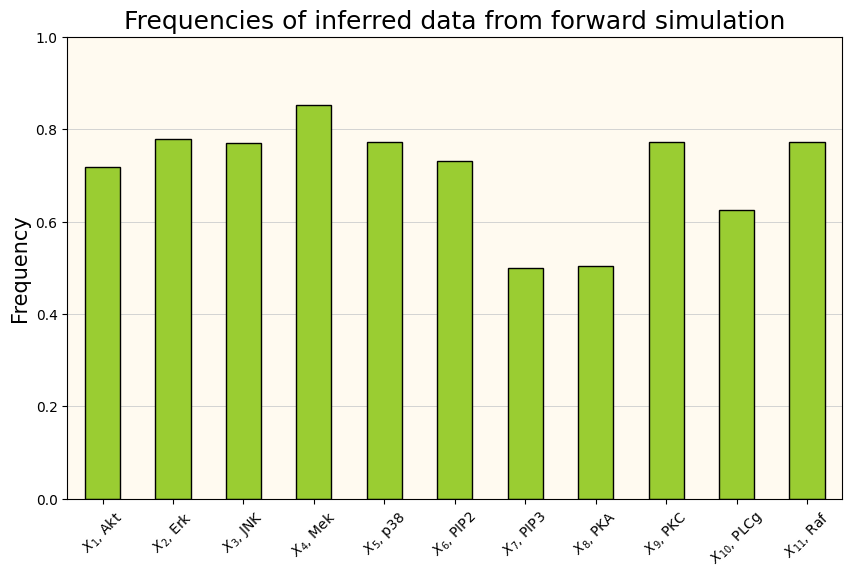

In [69]:
percentages_inf_sim = inf_sim_50K.mean()  # mean() calculates the proportion of 1s, multiplying by 100 gives the percentage
categories = ['$X_1$, Akt' , '$X_2$, Erk' ,'$X_3$, JNK' , '$X_4$, Mek' , '$X_5$, p38' , '$X_6$, PIP2' , '$X_7$, PIP3' , '$X_8$, PKA' , '$X_9$, PKC', '$X_{10}$, PLCg', '$X_{11}$, Raf']
n = len(categories)


# Plotting
fig1, ax = plt.subplots(figsize=(10,6))
percentages_inf_sim.plot(kind='bar', ax=ax,color='yellowgreen',edgecolor='black')
plt.ylabel('Frequency',fontsize=15)
plt.ylim(0,1)
plt.xticks(ticks=np.arange(n),labels=categories, rotation=45)
plt.title('Frequencies of inferred data from forward simulation',fontsize=18)
ax.set_facecolor('floralwhite')
ax.set_axisbelow(True)
plt.grid(axis='y', linestyle='-', linewidth=0.7,color='lightgray')  
plt.show()
fig1.savefig('inf_fwd_sim.png')

## Apply the inference algorithm on the original data

In [70]:
# load orginal data 
# Initialize the dataset - original data
column_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'remove1', 'remove2']
sachs_bin_dataset = pd.read_csv("dataset/sachs_bin.csv") 
sachs_bin_dataset = sachs_bin_dataset.rename(columns=dict(zip(sachs_bin_dataset.columns, column_names)))
#sachs_bin_dataset = sachs_bin_dataset.drop(columns=['remove1', 'remove2'], axis=0)


### Applying inference algorithm to sachs_bin.csv data

In [71]:
# remove '#' to run the inference algorithm on the real data
#variables_to_eliminate = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']
#query_var = ['X10', 'X11']
#sachs_bin_inferred = dataframe_inference(sachs_bin_dataset, column_names, query_var, variables_to_eliminate)
#sachs_bin_inferred = sachs_bin_inferred.drop(columns=['X10_prob', 'X11_prob'], axis=0)
#sachs_bin_inferred.to_csv('dataset/sachs_bin_inferred.csv', index=False)

In [72]:
# importing saved data from inference algorithm
sachs_bin_inferred = pd.read_csv('dataset/sachs_bin_inferred.csv')
percentages_sachs = sachs_bin_inferred.mean()  # mean() calculates the proportion of 1s, multiplying by 100 gives the percentage

In [73]:
fwd_sim_50K = pd.read_csv('dataset/50K_forward_simulation.csv')

### Plot all data together

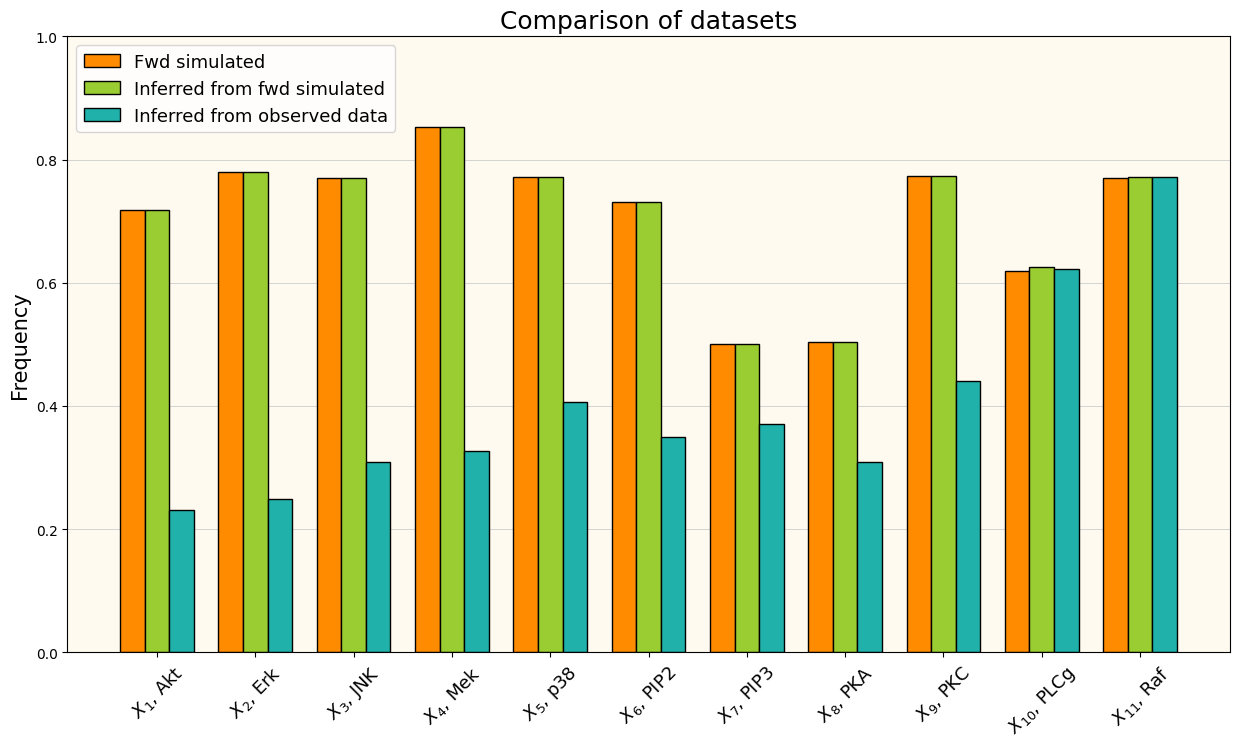

In [74]:
datasets = ['Fwd simulated', 'Inferred from fwd simulated', 'Inferred from observed data']
categories = ['$X_1$, Akt' , '$X_2$, Erk' ,'$X_3$, JNK' , '$X_4$, Mek' , '$X_5$, p38' , '$X_6$, PIP2' , '$X_7$, PIP3' , '$X_8$, PKA' , '$X_9$, PKC' , '$X_{10}$, PLCg' , '$X_{11}$, Raf']

# Define width of each bar
bar_width = 0.25

# Set positions for bars on X-axis
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

fwd_sim = fwd_sim_50K.mean()
inf_fwd = percentages_inf_sim
inf_sachs = percentages_sachs

#ax = plt.subplots()
fig1,ax = plt.subplots(figsize=(15, 8))

ax.bar(r1,fwd_sim,color='darkorange',width=bar_width,label=datasets[0],edgecolor='black')
ax.bar(r2,inf_fwd,color='yellowgreen',width=bar_width,label=datasets[1],edgecolor='black')
ax.bar(r3,inf_sachs,color='lightseagreen',width=bar_width,label=datasets[2],edgecolor='black')

plt.ylabel('Frequency',fontsize=15)
plt.ylim(0,1)
plt.xticks([r + bar_width for r in range(len(categories))], categories, rotation=45,fontsize=13)
plt.title('Comparison of datasets',fontsize=18)
ax.set_facecolor('floralwhite')
ax.set_axisbelow(True)
plt.grid(axis='y', linestyle='-', linewidth=0.7,color='lightgray')  # Add gridlines for better readability

# Add legend
plt.legend(loc='upper left',fontsize=13)

plt.show()

fig1.savefig('comparison_part_ii.png')

# Part III

## Qustion 1

In [75]:
elimination_scope = [("X1", ['X7', 'X8']),("X2", ['X4', 'X8']),("X3", ['X9', 'X8']),
                     ("X5", ['X9', 'X8']),("X4", ['X11', 'X8', 'X9']),("X6", ['X7', 'X10']),
                     ("X7", []),("X8", []),("X9", ['X10', 'X6']), ("X10", ['X7']),("X11", ['X8', 'X9'])]

df = pd.read_csv('dataset/forward_simulation.csv')
print(df.head())

   X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  X11
0   1   1   1   1   1   1   0   1   0    1    0
1   1   0   1   0   1   1   0   0   1    1    0
2   1   1   0   1   0   0   1   0   1    1    1
3   1   1   1   1   1   1   0   1   1    0    1
4   1   1   1   1   1   1   1   1   1    1    1


In [76]:
# Generate possible binary combinations in the same format as predict_proba requires
def generate_binary_combinations(n):
    # Python magic to generate all possible combinations of 0 and 1 in a string format
    str_combinations = [format(i, f"0{n}b") for i in range(2**n)]
    lst_combinations = []

    # Loops through all the string and converts them to a list of integers
    for elm in str_combinations:
        lst_elm = list(elm)
        for i in range(len(lst_elm)):
            lst_elm[i] = int(lst_elm[i])
        lst_combinations.append(lst_elm)
    return lst_combinations

print(generate_binary_combinations(3))

[[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]


In [77]:
inp_1 = ['X7']
out_1 = ['X10'] 

def log_reg_cpd(inp, out, df):
    # Splitting data into predictors (X) and outcome (y)
    X = df[inp]
    y = df[out]

    # Fit the logistic regression model
    warnings.filterwarnings("ignore")
    model = LogisticRegression()
    model.fit(X, y)

    # Predict probabilities for all combinations of 1's and 0's from parents
    combinations = generate_binary_combinations(len(inp))
    predictions = model.predict_proba(combinations)

    # Extracting the probabilities of child = 1
    probabilities = predictions[:, 1]

    # The two list combinations and probabilities are combined into a single list
    for i in range (len(combinations)):
        combinations[i].append(probabilities[i])

    #Generate columns
    col_names = inp + ['prob']
    probabilities_df = pd.DataFrame(columns=col_names, data=combinations)

    return probabilities_df

log_reg_cpd(inp_1, out_1, df)

,X7,prob
0,0,0.516200
1,1,0.751899


## Qustion 2

In [78]:
# The factor list (luckily) should be in the same order as bh_structure (The elmination order)
bn_structure = [("X1", ['X7', 'X8']),("X2", ['X4', 'X8']),("X3", ['X9', 'X8']),
                ("X5", ['X9', 'X8']),("X4", ['X11', 'X8', 'X9']),("X6", ['X7', 'X10']),
                ("X7", []),("X8", []),("X9", ['X10', 'X6']), ("X10", ['X7']),("X11", ['X8', 'X9'])]



def data_to_factors(df, bn_structure):
    ''' 
    Takes a dataframe and a Bayesian network, and run the logist regression algorithm on the data to generate the cpd's
    and then we convert into factors.
    
    Arguments:
    df (pandas.DataFrame): The dataframe containing all columns
    bn_structure (list): list defined above. The Bayesian network structure

    Returns:
    lst (list): list of factors (pandas.DataFrame). [ ( 'Xi', ), ...]
    '''
    lst = []
    for elm in bn_structure:
        if elm[1] != []:
            df_factor_ = log_reg_cpd(elm[1], [elm[0]], df)
            df_factor_[elm[0]] = 1
            
            # Change to cpd format
            df_factor_zero = df_factor_.copy() # copy
            df_factor_zero[elm[0]] = 0 # Change column to 0
            df_factor_zero["prob"] = 1 - df_factor_zero["prob"] # Calculate the probability of 0
            df_factor_ = pd.concat([df_factor_, df_factor_zero]) # Combine the dataframe with the 0's with the original
            lst = lst + [(df_factor_, elm[0])]
        else:
            # We cannot learn without parents, so this is an exception for the root nodes
            # We we just calculate the probability "manually"
            sum_elm = df[elm[0]].sum()
            num_rows = len(df)
            result = sum_elm / num_rows
            df_factor_ = pd.DataFrame(data=[[0, result], [1, 1-result]], columns=[elm[0], 'prob'])
            lst = lst + [(df_factor_, elm[0])]
    return lst

data_to_factors(df, bn_structure)

[(   X7  X8      prob  X1
  0   0   0  0.524439   1
  1   0   1  0.752978   1
  2   1   0  0.747443   1
  3   1   1  0.891073   1
  0   0   0  0.475561   0
  1   0   1  0.247022   0
  2   1   0  0.252557   0
  3   1   1  0.108927   0,
  'X1'),
 (   X4  X8      prob  X2
  0   0   0  0.511150   1
  1   0   1  0.703735   1
  2   1   0  0.767469   1
  3   1   1  0.882323   1
  0   0   0  0.488850   0
  1   0   1  0.296265   0
  2   1   0  0.232531   0
  3   1   1  0.117677   0,
  'X2'),
 (   X9  X8      prob  X3
  0   0   0  0.498349   1
  1   0   1  0.700396   1
  2   1   0  0.726452   1
  3   1   1  0.862057   1
  0   0   0  0.501651   0
  1   0   1  0.299604   0
  2   1   0  0.273548   0
  3   1   1  0.137943   0,
  'X3'),
 (   X9  X8      prob  X5
  0   0   0  0.543301   1
  1   0   1  0.761424   1
  2   1   0  0.745390   1
  3   1   1  0.887059   1
  0   0   0  0.456699   0
  1   0   1  0.238576   0
  2   1   0  0.254610   0
  3   1   1  0.112941   0,
  'X5'),
 (   X11  X8  X9      pr

## Qustion 3

In [79]:
#Algorithm 19.2 in PGM - Page 298 (pdf: 910)

# M-matrix, for x_10: X_10, X_7
# Bayesian network structure
bn_structure = [("X1", ['X7', 'X8']),("X2", ['X4', 'X8']),("X3", ['X9', 'X8']),
                ("X5", ['X9', 'X8']),("X4", ['X11', 'X8', 'X9']),("X6", ['X7', 'X10']),
                ("X7", []),("X8", []),("X9", ['X10', 'X6']), ("X10", ['X7']),("X11", ['X8', 'X9'])]

# Generate empty list of cpd's
for elm in factor_list:
    elm[0]['prob'] = [np.random.rand() for _ in range(elm[0].shape[0])]
print(factor_list)


# Partially observed data
# Initialize the dataset - simulated data
column_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'remove1', 'remove2']
fwd_sim_1k = pd.read_csv("dataset/forward_simulation.csv") 
fwd_sim_1k = fwd_sim_1k.rename(columns=dict(zip(fwd_sim_1k.columns, column_names)))
fwd_sim_1k = fwd_sim_1k.drop(columns=['remove1', 'remove2'], axis=0)

# Variables that we want to learn and want to eleminate in sum_product_ve
query_var = ['X10', 'X11']
variables_to_eliminate = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']

print(fwd_sim_1k.head())

[(   X7  X8  X1      prob
0   0   0   0  0.179594
1   0   0   1  0.042453
2   0   1   0  0.636236
3   0   1   1  0.732750
4   1   0   0  0.483652
5   1   0   1  0.890093
6   1   1   0  0.089219
7   1   1   1  0.045566, 'phi_X1'), (   X4  X8  X2      prob
0   0   0   0  0.082125
1   0   0   1  0.195999
2   0   1   0  0.442724
3   0   1   1  0.576199
4   1   0   0  0.234380
5   1   0   1  0.607368
6   1   1   0  0.594045
7   1   1   1  0.488266, 'phi_X2'), (   X9  X8  X3      prob
0   0   0   0  0.213550
1   0   0   1  0.132609
2   0   1   0  0.361104
3   0   1   1  0.054579
4   1   0   0  0.070245
5   1   0   1  0.065301
6   1   1   0  0.450757
7   1   1   1  0.978141, 'phi_X3'), (   X9  X8  X5      prob
0   0   0   0  0.808554
1   0   0   1  0.445126
2   0   1   0  0.808130
3   0   1   1  0.661205
4   1   0   0  0.044088
5   1   0   1  0.626978
6   1   1   0  0.011410
7   1   1   1  0.817988, 'phi_X5'), (    X11  X8  X9  X4      prob
0     0   0   0   0  0.798754
1     0   0   0   1  0

In [82]:
# Return the inference data
def compute(G, df, parameters):
    evidence = dataframe_to_evidence(df, column_names)
    df['X10'] = 0
    df['X11'] = 0

    for i in range(0, len(evidence)):
        for j in ['X10', 'X11']:
            query_var = [j]
            variables_to_eliminate = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']
            prob = cond_prob_ve(parameters, query_var, evidence[i], variables_to_eliminate)[0]
            value = prob[prob[j] == 1]['prob'].values[0]
            if value < 0.5:
                df[j][i] = 0
            else:
                df[j][i] = 1

    return df

compute(bn_structure, fwd_sim_1k, factor_list)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,1,1,1,1,1,1,0,1,0,0,1
1,1,0,1,0,1,1,0,0,1,0,0
2,1,1,0,1,0,0,1,0,1,0,0
3,1,1,1,1,1,1,0,1,1,0,1
4,1,1,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,0,0,0,1,0,1,0,0,1
996,1,1,0,0,1,1,1,1,0,1,1
997,0,1,1,0,1,1,0,0,1,0,0
998,1,1,1,1,1,0,1,0,1,0,0


In [84]:
def em(G, parameters, df, max_iter=10):
    for i in range(max_iter):
        # E-step
        data = compute(G, df, parameters)
        # M-step
        parameters = data_to_factors(data, G)
        print(parameters[10])
    
    return parameters
 
em(bn_structure, factor_list, fwd_sim_1k, max_iter=10)

(   X8  X9      prob  X11
0   0   0  0.665316    1
1   0   1  0.029715    1
2   1   0  0.999701    1
3   1   1  0.980942    1
0   0   0  0.334684    0
1   0   1  0.970285    0
2   1   0  0.000299    0
3   1   1  0.019058    0, 'X11')
(   X8  X9      prob  X11
0   0   0  0.665316    1
1   0   1  0.029715    1
2   1   0  0.999701    1
3   1   1  0.980942    1
0   0   0  0.334684    0
1   0   1  0.970285    0
2   1   0  0.000299    0
3   1   1  0.019058    0, 'X11')
(   X8  X9      prob  X11
0   0   0  0.665316    1
1   0   1  0.029715    1
2   1   0  0.999701    1
3   1   1  0.980942    1
0   0   0  0.334684    0
1   0   1  0.970285    0
2   1   0  0.000299    0
3   1   1  0.019058    0, 'X11')
(   X8  X9      prob  X11
0   0   0  0.665316    1
1   0   1  0.029715    1
2   1   0  0.999701    1
3   1   1  0.980942    1
0   0   0  0.334684    0
1   0   1  0.970285    0
2   1   0  0.000299    0
3   1   1  0.019058    0, 'X11')
(   X8  X9      prob  X11
0   0   0  0.665316    1
1   0   1  0.